In [1]:
import os
import sys

import torch
import torchvision
import matplotlib
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from pprint import pprint
from torchvision import transforms as T

print("Import dependencies...")

Import dependencies...


In [2]:
class PASTA:
    """
    PASTA: Proportional Amplitude Spectrum Augmentation for Synthetic-to-Real Domain Generalization

    ...

    Attributes
    ----------
    alpha : float
        coefficient of linear term to ensure perturbation strength increases 
        with increasing spatial frequency
    beta : float
        constant perturbation across all frequencies
    k : int
        exponent ensuring non-linear dependence of perturbation on spatial
        frequency

    """
    def __init__(self, alpha: float, beta: float, k: int):
        self.alpha = alpha
        self.beta = beta
        self.k = k
    
    def __call__(self, img: torch.Tensor) -> torch.Tensor:
        fft_src = torch.fft.fftn(img, dim=[-2, -1])
        amp_src, pha_src = torch.abs(fft_src), torch.angle(fft_src)

        X, Y = amp_src.shape[1:]
        X_range, Y_range = None, None

        if X % 2 == 1:
            X_range = np.arange(-1 * (X // 2), (X // 2) + 1)
        else:
            X_range = np.concatenate(
                [np.arange(-1 * (X // 2) + 1, 1), np.arange(0, X // 2)]
            )

        if Y % 2 == 1:
            Y_range = np.arange(-1 * (Y // 2), (Y // 2) + 1)
        else:
            Y_range = np.concatenate(
                [np.arange(-1 * (Y // 2) + 1, 1), np.arange(0, Y // 2)]
            )

        XX, YY = np.meshgrid(Y_range, X_range)

        exp = self.k
        lin = self.alpha
        offset = self.beta

        inv = np.sqrt(np.square(XX) + np.square(YY))
        inv *= (1 / inv.max()) * lin
        inv = np.power(inv, exp)
        inv = np.tile(inv, (3, 1, 1))
        inv += offset
        prop = np.fft.fftshift(inv, axes=[-2, -1])
        amp_src = amp_src * np.random.normal(np.ones(prop.shape), prop)

        aug_img = amp_src * torch.exp(1j * pha_src)
        aug_img = torch.fft.ifftn(aug_img, dim=[-2, -1])
        aug_img = torch.real(aug_img)
        aug_img = torch.clip(aug_img, 0, 1)
        return aug_img

In [3]:
torch.manual_seed(1)

def apply_pasta(syn_img, alpha=3.0, beta=0.25, k=2):
    syn_transform = T.Compose(
        [
            T.ToTensor(),
            PASTA(alpha=alpha, beta=beta, k=k),
            T.ToPILImage(),
        ]
    )
    aug_syn_img = syn_transform(syn_img)
    print("Original Image")
    plt.imshow(syn_img)
    plt.show()
    print("PASTA Augmented Image")
    print("α = {}, β = {}, k = {}".format(alpha, beta, k))
    plt.imshow(aug_syn_img)

In [4]:
syn_dir = "media/synthetic_images"
syn_imgs = [Image.open(os.path.join(syn_dir, x)) for x in os.listdir(syn_dir)]

Original Image


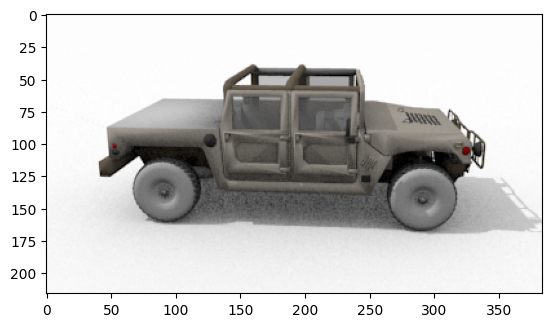

PASTA Augmented Image
α = 3.0, β = 0.25, k = 2


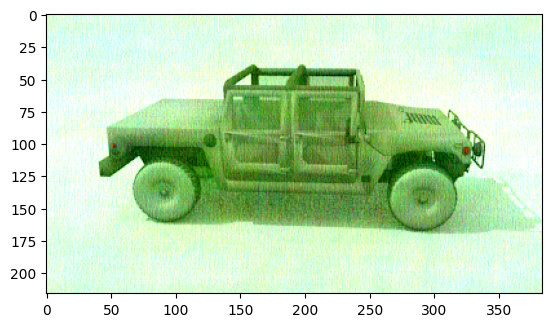

In [5]:
apply_pasta(syn_imgs[0], 3.0, 0.25, 2)

Original Image


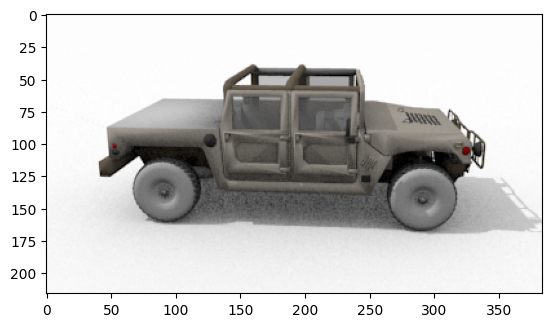

PASTA Augmented Image
α = 10.0, β = 0.25, k = 2


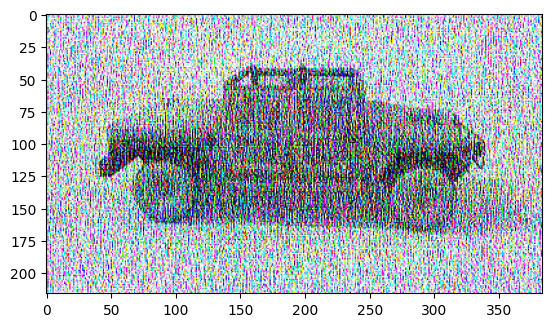

In [6]:
apply_pasta(syn_imgs[0], 10.0, 0.25, 2)

Original Image


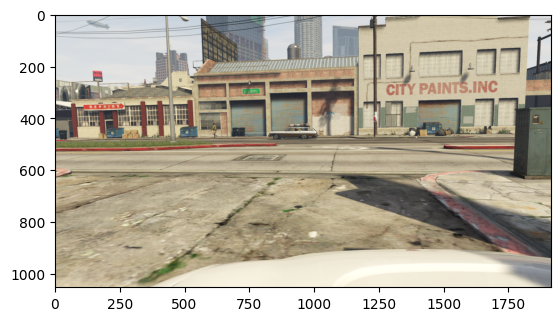

PASTA Augmented Image
α = 3.0, β = 0.25, k = 2


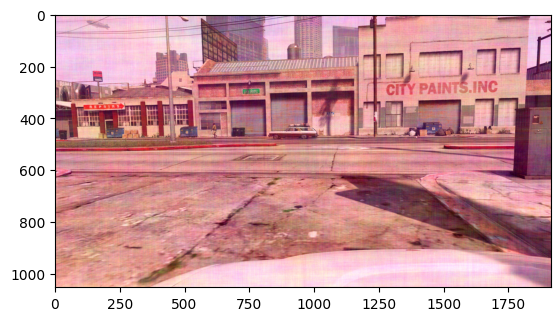

In [7]:
apply_pasta(syn_imgs[1], 3.0, 0.25, 2)

Original Image


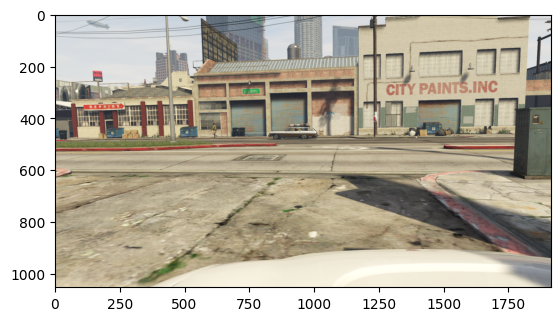

PASTA Augmented Image
α = 10.0, β = 0.25, k = 2


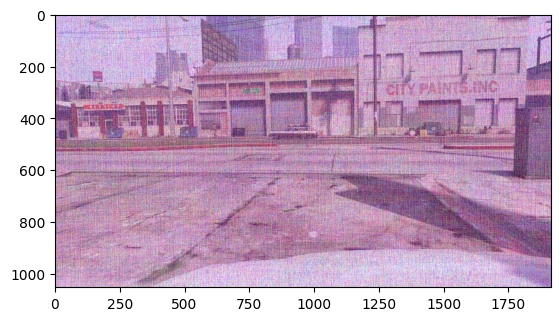

In [8]:
apply_pasta(syn_imgs[1], 10.0, 0.25, 2)